# Scanning separations and orientations

In [1]:
import re
import numpy as np
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams.update({"font.size" : 22})

In [2]:
def read_xyz(file_name = ""):
    angstrom_to_bohr = 1.88973

    if file_name == "":
        lines = list(open("../monomer_xyzs/trunc_bchla_1_frame_1.xyz"))
    else:
        lines = list(open("added_noise.xyz"))
    
    symbols = [] 
    coords = []
    
    lines = lines[2:]

    for line in lines:
        symbol = re.findall(r'[a-zA-Z]+', line)
        coord  = np.array([float(y) * angstrom_to_bohr for y in re.findall(r'-?\d+.\d+', line)])
            
        if len(symbol) == 0 or len(coord) == 0:
            continue
                
        symbols.append(symbol[0])
        coords.append(coord)
    
    return symbols, coords

In [3]:
def angle(vec1, vec2):
    num = np.dot(vec1, vec2)
    dom = np.linalg.norm(vec1) * np.linalg.norm(vec2)
    
    angle = np.rad2deg(np.arccos(num/dom))
    
    return angle

angstrom_to_bohr = 1.88973
Na_index = 14
Nb_index = 5
Nc_index = 31
Nd_index = 23

symbols, coords = read_xyz()
Na_Nc = coords[Na_index] - coords[Nc_index]
Nb_Nd = coords[Nb_index] - coords[Nd_index]

Qy_Qx_angle = angle(Na_Nc, Nb_Nd)

normal_to_porphyrin_plane = np.cross(Na_Nc, Nb_Nd)

unit_normal = normal_to_porphyrin_plane / np.linalg.norm(normal_to_porphyrin_plane)


In [4]:
#noise = np.load("noise.txt", allow_pickle=True)

#symbols, coords = read_xyz()
#origin_coords = [x - coords[0] for x in coords]
#added_noise = origin_coords + noise

#random_test = open(f"added_noise.xyz", 'w')

#print(f"{79}", file = random_test)
#print("", file = random_test)

#for enum, c in enumerate(coords):
#    print(symbols[enum], np.array2string(added_noise[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=random_test)

In [5]:
%%bash
./test_random.sh

 Excitation energy:                      0.094811642
 Excitation energy (in eV):              2.579956205
 Excitation energy:                      0.095287851
 Excitation energy (in eV):              2.592914508


## Scan distances

In [6]:
angstrom_to_bohr = 1.88973

def write_separation_files():
    symbols, coords = read_xyz()
    
    origin_coords = [x - coords[0] for x in coords]
    _, noise_coords = read_xyz("added_noise.xyz")
    
    full_scan = open(f"sep_xyzs/full_scan.xyz", 'w')
    
    
    for sep in np.linspace(15, 100, 17):
        dimer_file = open(f"sep_xyzs/dimer_sep_{int(sep)}.xyz", 'w')
        origin_monomer = open(f"sep_xyzs/origin.xyz", 'w')
        moved_monomer = open(f"sep_xyzs/monomer_sep_{int(sep)}.xyz", 'w')
        
        moved_coords = [x+unit_normal * sep for x in noise_coords]

        print(f"{79*2}", file=dimer_file)
        print(f"{79*2}", file=full_scan)
        print(f"{79}", file=origin_monomer)
        print(f"{79}", file=moved_monomer)
        
        print("", file=dimer_file)
        print("", file=full_scan)
        print("", file=origin_monomer)
        print("", file=moved_monomer)

        for enum, c in enumerate(origin_coords):
            print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=dimer_file)
            print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=full_scan)
            print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=origin_monomer)

        for enum, c in enumerate(moved_coords):
            print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=dimer_file)
            print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=full_scan)
            print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=moved_monomer)
            
            
        
        dimer_file.close()
        origin_monomer.close()
        moved_monomer.close()
    
    full_scan.close()

## Scan angles

In [7]:
def rotation_matrix(normal, angle):
    cos = np.cos(angle)
    sin = np.sin(angle)
    
    cross_product_matrix = np.array([
                                    [ 0,         -normal[2],  normal[1]],
                                    [ normal[2],  0,         -normal[0]],
                                    [-normal[1],  normal[0],  0        ]
                                   ])
    
    outer_product = np.outer(normal, normal)
    
    identity = np.identity(3)
    
    R = cos * identity + sin * cross_product_matrix + (1-cos) * outer_product
    
    return R

def write_angle_files():
    symbols, coords = read_xyz()
    _, noise_coords = read_xyz("added_noise.xyz")
    
    origin_coords = [x - coords[0] for x in coords]
    
    for sep in [15, 17, 20, 25, 30, 60]:
        full_scan = open(f"angle_xyzs/full_scan_sep_{sep}.xyz", 'w')
        
        for theta in np.linspace(0, 2*np.pi, 100):
            dimer_file = open(f"angle_xyzs/sep_{sep}_dimer_angle_{int(np.rad2deg(theta))}.xyz", 'w')
            origin_monomer = open(f"angle_xyzs/origin.xyz", 'w')
            moved_monomer = open(f"angle_xyzs/sep_{sep}_monomer_angle_{int(np.rad2deg(theta))}.xyz", 'w')

            rotation = rotation_matrix(unit_normal, theta)

            moved_coords = [np.dot(rotation, (x+(unit_normal*sep))) for x in noise_coords]

            print(f"{79*2}", file=dimer_file)
            print(f"{79*2}", file=full_scan)
            print(f"{79}", file=origin_monomer)
            print(f"{79}", file=moved_monomer)

            print("", file=dimer_file)
            print("", file=full_scan)
            print("", file=origin_monomer)
            print("", file=moved_monomer)

            for enum, c in enumerate(coords):
                print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=dimer_file)
                print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=full_scan)
                print(symbols[enum], np.array2string(origin_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=origin_monomer)

            for enum, c in enumerate(moved_coords):
                print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=dimer_file)
                print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=full_scan)
                print(symbols[enum], np.array2string(moved_coords[enum] / angstrom_to_bohr, formatter={'float_kind':lambda x: "%.5f" % x})[1:-1], file=moved_monomer)
            
            dimer_file.close()
            origin_monomer.close()
            moved_monomer.close()
            
        full_scan.close()


In [8]:
#write_separation_files()
#write_angle_files()

In [9]:
import os
import sys
import importlib 

sys.path.insert(0, '..')
import read_Bchla_xTB
importlib.reload(read_Bchla_xTB)
import read_tddft
importlib.reload(read_tddft)
import make_json
importlib.reload(make_json)
import data_objects
importlib.reload(data_objects)
import frenkel_hamiltonians
importlib.reload(frenkel_hamiltonians)

import matplotlib
matplotlib.rcParams.update({"font.size" : 22})


In [20]:
def get_Bchla_xTB_angle_results(separation):
    angles = []
    monomer_states = [[],[]]
    dimer_states = [[], [], [], [], []]
    dimer_norms = [[], [], [], []]
    frenkel_dipole_states = [[], [], []]
    frenkel_charge_states = [[], [], []]
    frenkel_no_coupling_states = [[], [], []]

    origin_result = read_Bchla_xTB.read_monomer_Bchla_xTB_file(f"AngleScans/Bchla_xTB/Bchla_origin.out")
    origin_structure = data_objects.Structure("", "", given_file_name=f"angle_xyzs/origin.xyz")

    for theta in np.linspace(0, 2*np.pi, 100):
        dimer_result = read_Bchla_xTB.read_dimer_Bchla_xTB_file(f"AngleScans/Bchla_xTB/Bchla_sep_{separation}_dimer_angle_{int(np.rad2deg(theta))}.out")
        
        monomer_result = read_Bchla_xTB.read_monomer_Bchla_xTB_file(f"AngleScans/Bchla_xTB/Bchla_sep_{separation}_monomer_angle_{int(np.rad2deg(theta))}.out")
        monomer_structure = data_objects.Structure("", "", given_file_name=f"angle_xyzs/sep_{separation}_monomer_angle_{int(np.rad2deg(theta))}.xyz")
        
        frenkel_dipole_result = frenkel_hamiltonians.run_Frenkel_Hamiltonian([origin_result, monomer_result], [origin_structure, monomer_structure], "dipole", state=True)
        frenkel_charge_result = frenkel_hamiltonians.run_Frenkel_Hamiltonian([origin_result, monomer_result], [origin_structure, monomer_structure], "charges", state=True)
                        
        frenkel_no_coupling = frenkel_hamiltonians.run_Frenkel_Hamiltonian([origin_result, monomer_result], [origin_structure, monomer_structure], "off", state=True)
            
        angles.append(np.rad2deg(theta))
        
        for enum, i in enumerate(frenkel_dipole_result.eigvals):
            frenkel_dipole_states[enum].append(i)
        
        for enum, i in enumerate(frenkel_charge_result.eigvals):
            frenkel_charge_states[enum].append(i)
            
        for enum, i in enumerate(frenkel_no_coupling.eigvals):
            frenkel_no_coupling_states[enum].append(i)
        
        dimer_states[0].append(dimer_result.total_energy)
            
        for enum, i in enumerate(dimer_result.state_energies):
            norm = np.linalg.norm(dimer_result.transition_dipoles[enum])
            dimer_states[enum+1].append(i)
            dimer_norms[enum].append(norm)
            
        monomer_sum = origin_result.total_energy + monomer_result.total_energy
        
        monomer_states[0].append(monomer_sum + origin_result.transition_energy)
        monomer_states[1].append(monomer_sum + monomer_result.transition_energy)

    return {"angles" : angles,
            "dimer_states" : dimer_states,
            "monomer_states" : monomer_states,
            "dimer_norms" : dimer_norms,
            "frenkel_dipole_states" : frenkel_dipole_states,
            "frenkel_charge_states" : frenkel_charge_states,
            "frenkel_no_coupling" : frenkel_no_coupling_states}

def get_TDDFT_angle_results(method):
    angles = []
    dimer_excitations = [[] for x in range(5)]
    dipole_excitations = [[],[]]

    origin_here, origin_energy, origin_tdm = read_tddft.read_monomer_TDDFT_file(f"AngleScans/{method}/{method}_origin.out")
    origin_structure = make_json.Structure("", "", given_file_name=f"angle_xyzs/origin.xyz")

    for theta in np.linspace(0, 2*np.pi, 100):
        dimer_here, dimer_energies, dimer_tdms = read_tddft.read_dimer_TDDFT_file(f"AngleScans/{method}/{method}_dimer_angle_{int(np.rad2deg(theta))}.out")

        monomer_here, monomer_energy, monomer_tdm = read_tddft.read_monomer_TDDFT_file(f"AngleScans/{method}/{method}_monomer_angle_{int(np.rad2deg(theta))}.out")

        dimer_tdm_mags = [np.linalg.norm(x) for x in dimer_tdms]

        monomer_structure = make_json.Structure("", "", given_file_name=f"angle_xyzs/monomer_angle_{int(np.rad2deg(theta))}.xyz")

        dipole_energies, dipole_coupling, dipole_angle = make_json.run_Frenkel_Hamiltonian(origin_energy, monomer_energy, origin_tdm, monomer_tdm, origin_charges, monomer_charges, origin_structure, monomer_structure, "dipole")

        if not dimer_here or not monomer_here:
            continue

        for enum, i in enumerate(dimer_energies):
            dimer_excitations[enum].append(i)

        angles.append(np.rad2deg(theta))
        dipole_excitations[0].append(dipole_energies[0])
        dipole_excitations[1].append(dipole_energies[1])
        
    return {"angles" : angles,
            "dimer_excitations" : dimer_excitations,
            "dipole_excitations" : dipole_excitations}
        
            

def get_Bchla_xTB_results(scan, separation):
    if scan == "angle":
        return get_Bchla_xTB_angle_results(separation)
    
def get_TDDFT_results(method, scan):
    if scan == "angle":
        return get_TDDFT_angle_results(method, separation)
    
    
def get_response_results(method, scan, separation):
    if method == "Bchla_xTB":
        return get_Bchla_xTB_results(scan, separation)
    else:
        return get_TDDFT_results(method, scan, separation)

In [21]:
Bchla_xTB_angles_15 = get_response_results("Bchla_xTB", "angle", 15)
Bchla_xTB_angles_17 = get_response_results("Bchla_xTB", "angle", 17)
Bchla_xTB_angles_20 = get_response_results("Bchla_xTB", "angle", 20)
Bchla_xTB_angles_25 = get_response_results("Bchla_xTB", "angle", 25)
Bchla_xTB_angles_30 = get_response_results("Bchla_xTB", "angle", 30)
Bchla_xTB_angles_60 = get_response_results("Bchla_xTB", "angle", 60)
#BLYP_angles = get_response_results("BLYP", "angle")

In [22]:
Bchla_xTB_angles_17['frenkel_no_coupling']

[[-261.8193777985603,
  -261.81942699990736,
  -261.81949901922127,
  -261.81957752919527,
  -261.81966426060245,
  -261.81975750272863,
  -261.81986440841007,
  -261.81996530962726,
  -261.82006999938335,
  -261.8201704817811,
  -261.8202664621176,
  -261.8203680595172,
  -261.82044921935466,
  -261.8205172421597,
  -261.8205907276709,
  -261.82064534898365,
  -261.8206909222284,
  -261.82072546167603,
  -261.8207473070837,
  -261.82075372812886,
  -261.82074746567554,
  -261.820750400223,
  -261.8207335445355,
  -261.8207032467812,
  -261.8206817216652,
  -261.82064256217257,
  -261.8206085337215,
  -261.8205699296212,
  -261.82051899153316,
  -261.82046834989904,
  -261.8204197152435,
  -261.8203586337253,
  -261.82029575970057,
  -261.8202321835872,
  -261.8201693460451,
  -261.820101766401,
  -261.8200224848597,
  -261.8199539486612,
  -261.8198818222911,
  -261.8198079690432,
  -261.8197287405896,
  -261.81966493084144,
  -261.8195997212211,
  -261.81953598853016,
  -261.81949127

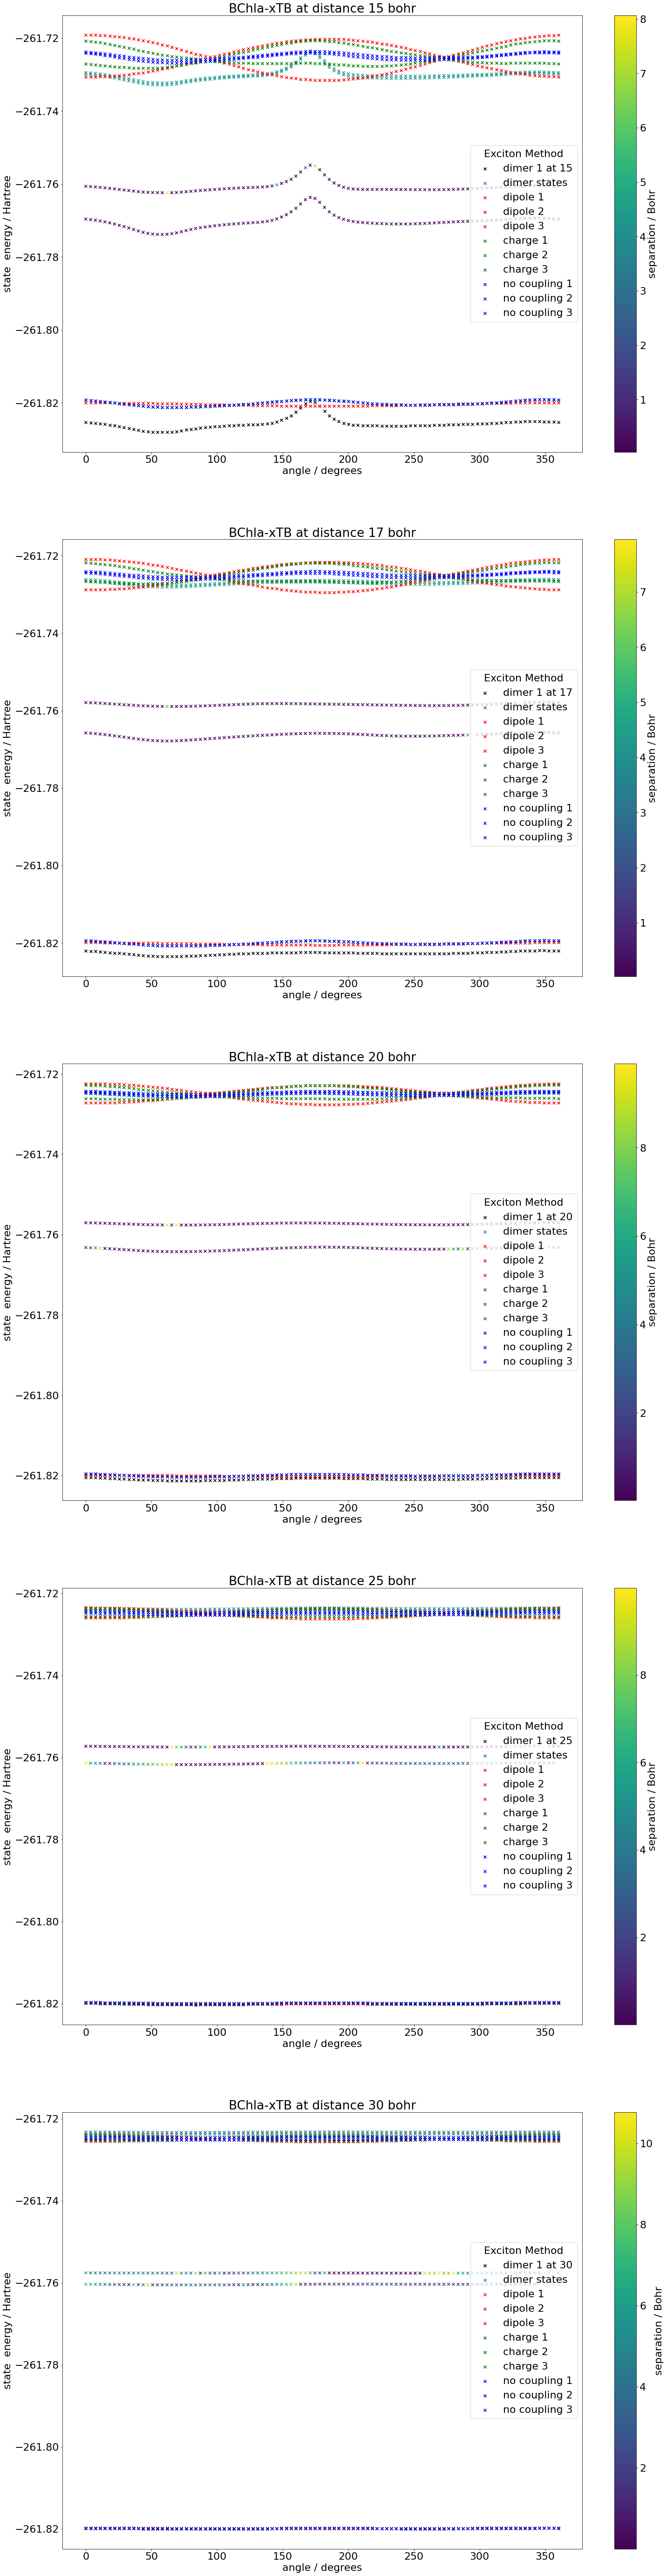

In [24]:
distances = [15, 17, 20, 25, 30, 60]

scans = [Bchla_xTB_angles_15,
         Bchla_xTB_angles_17,
         Bchla_xTB_angles_20,
         Bchla_xTB_angles_25,
         Bchla_xTB_angles_30,
        ]

fig, ax = plt.subplots(5,1)

marker = 'x'

for axis, scan, distance in zip(ax.ravel(), scans, distances):
    axis.scatter(scan["angles"], scan["dimer_states"][0], color='black', marker=marker, label=f"dimer 1 at {distance}")
    
    all_angles = []
    all_states = []
    all_norms = []
    
    for i in range(4):
        for angle in scan["angles"]:
            all_angles.append(angle)
        for state in scan["dimer_states"][i+1]:
            all_states.append(state)
        for norm in scan["dimer_norms"][i]:
            all_norms.append(norm)

    cax = axis.scatter(all_angles, all_states, c=all_norms, marker=marker, label=f"dimer states")
    
    #axis.hlines(scan["monomer_states"][0], xmin=0, xmax=360, color='black', linestyle='--', label="monomer")
    #axis.hlines(scan["monomer_states"][1], xmin=0, xmax=360, color='black', linestyle='--', label="monomer")
    
    axis.scatter(scan["angles"], scan["frenkel_dipole_states"][0], color='red', marker=marker, label=f"dipole 1")
    axis.scatter(scan["angles"], scan["frenkel_dipole_states"][1], color='red', marker=marker, label=f"dipole 2")
    axis.scatter(scan["angles"], scan["frenkel_dipole_states"][2], color='red', marker=marker, label=f"dipole 3")
    axis.scatter(scan["angles"], scan["frenkel_charge_states"][0], color='green', marker=marker, label=f"charge 1")
    axis.scatter(scan["angles"], scan["frenkel_charge_states"][1], color='green', marker=marker, label=f"charge 2")
    axis.scatter(scan["angles"], scan["frenkel_charge_states"][2], color='green', marker=marker, label=f"charge 3")
    axis.scatter(scan["angles"], scan["frenkel_no_coupling"][0], color='blue', marker=marker, label=f"no coupling 1")
    axis.scatter(scan["angles"], scan["frenkel_no_coupling"][1], color='blue', marker=marker, label=f"no coupling 2")
    axis.scatter(scan["angles"], scan["frenkel_no_coupling"][2], color='blue', marker=marker, label=f"no coupling 3")

    
    axis.set_xlabel("angle / degrees")
    axis.set_ylabel("state  energy / Hartree")
    axis.legend(title="Exciton Method")
    
    cbar = fig.colorbar(cax, ax=axis)
    cbar.set_label("separation / Bohr")


    axis.set_title(f"BChla-xTB at distance {distance} bohr")
    
    #axis.set_ylim(-261.735, -261.717)


fig.set_size_inches(25, 100)

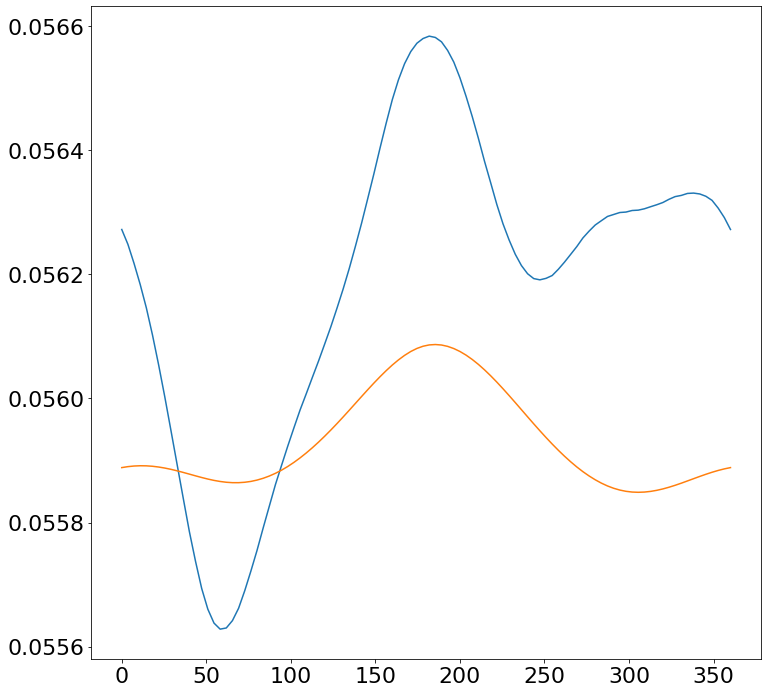

In [25]:
fig, ax = plt.subplots()

diff1 = np.array(Bchla_xTB_angles_17["dimer_states"][1]) - np.array(Bchla_xTB_angles_17["dimer_states"][0])
diff2 = np.array(Bchla_xTB_angles_17["dimer_states"][2]) - np.array(Bchla_xTB_angles_17["dimer_states"][0])

ax.plot(Bchla_xTB_angles_17["angles"], diff1)
ax.plot(Bchla_xTB_angles_17["angles"], diff2 - 0.04)

fig.set_size_inches(12,12)